# Nearest Neighbors Housing Appraiser (NeaNHA)

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor


from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

import joblib

import PaulBettany as jarvis


pd.options.display.max_columns = 100
pd.options.display.max_rows = 2000


seed=1

## Curse of Dimensionality

Since KNN relies on distance, it is especially susceptible to the curse of dimensionality. To illustrate the issue, suppose we wanted to use 10 features and train a KNN model using Euclidean distance. Take two points $x,y\in \mathbb{R}^{10}$. In order for $x$ and $y$ to be within a distance of 1 to each other, we would need $ 1 >|| x-y || $ which is equivalent to $1 > || x-y||^2$. Therefore:

<br> 

$$1 > ||x-y||^2 = (x_1-y_1)^2+\ldots+(x_{10}-y_{10})^2$$

<br>

$$ \frac{1}{10} > \frac{\sum_{i=1}^{10}(x_i-y_i)^2}{10} = \mathbb{E}\left[(x_i-y_i)^2\right]$$

<br>

In other words, the expected square difference across all 10 coordinates has to be at most 0.1 which is a very strict requirement. If we were in 100-dimensions, the expected square difference would have to be at most 0.01 and so on. The point is as we grow from 10 to 100 to 10,000 dimensions, it becomes harder and harder for data points to stay close to each other. The about it: in order for $x$ and $y$ to be close, *all* the components $x_i$ and $y_i$ must be close. On the other hand, *it just takes 1 component*, say $x_1$ and $y_1$ to be far in order for $x$ and $y$ to be far apart. This phenomena where data points tend to drift further apart as we increase dimensions is called **the curse of dimensionality**.

For KNN which hinges on similar data points being close to make good predictions, this curse of dimensionality can become quite a problem if our data set isn't robust with large number of examples. For this reason, we'll try to restrict ourselves to a small number of features.

In [29]:
# load data
train = pd.read_csv('../data/train.csv', index_col = 'Id')
data = pd.read_csv('../data/ames-cleaned.csv', index_col = 'Id')

In [30]:
data.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Gara

In [31]:
# combine features to decrease the number of dimensions
data['1st + 2nd Flr'] = data['1st Flr SF'] + data['2nd Flr SF']


In [32]:
# list out features to use
features = ['Lot Area', 'Overall Qual', 'Year Built', '1st + 2nd Flr', 'Gr Liv Area', 'TotRms AbvGrd', 'Garage Area']

data_nn = data[features]

In [33]:
X = data_nn[:len(train.index) ]
Xkaggle = data_nn[len(train.index) : ]
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

zscale = StandardScaler()

Xs_train = zscale.fit_transform(X_train)
Xs_test = zscale.transform(X_test)
Xs_kaggle = zscale.transform(Xkaggle)


In [34]:
# parameter grid for number of neighbors and which norm to use
# (p=1 is Manhattan, p=2 is Euclidean)
params = { 'n_neighbors' : [7,8,9,10,11,12,13],
            'p' : [1, 2]
         }

In [35]:
# Instantiate NeanHa Mk. 1
neanhamk1 = GridSearchCV(KNeighborsRegressor(n_jobs=-1),
                         param_grid = params,
                         scoring = 'neg_mean_absolute_error',
                         n_jobs=-1)
                         

In [36]:
neanhamk1.fit(Xs_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [7, 8, 9, 10, 11, 12, 13], 'p': [1, 2]},
             scoring='neg_mean_absolute_error')

In [37]:
neanhamk1.best_estimator_

KNeighborsRegressor(n_jobs=-1, n_neighbors=10, p=1)

In [38]:
jarvis.grade_model(neanhamk1, Xs_train, y_train, display=True), jarvis.grade_model(neanhamk1, Xs_test, y_test, display=True);

 
R2 :0.871161158116655
MSE: 786535925.3345426
RMSE: 28045.247820879435
MAE: 18652.059329268293
 
 
R2 :0.8507188762847456
MSE: 1040255387.9668126
RMSE: 32252.990372472635
MAE: 20775.732846715327
 


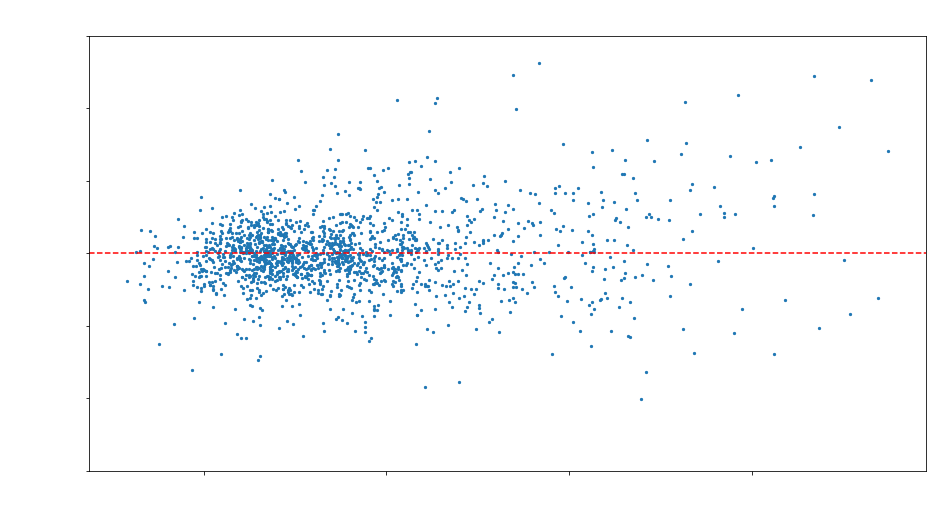

In [40]:
plt.figure(figsize = (15,8));

plt.scatter(x=neanhamk1.predict(Xs_train), y=y_train - neanhamk1.predict(Xs_train), s=5);
plt.axhline(y=0, c='red', linestyle='--');
plt.xticks(c='white');
plt.yticks(c='white');
plt.title('NeaNHA Mk 1 (Train Residuals)', c='white', fontsize=30);
plt.ylim((-150_000, 150_000))
plt.xlabel('Predicted Price', c='white', fontsize=25);
plt.ylabel('Error', c='white', fontsize=25);

plt.savefig('../images/neanhamk1-residuals.png');